In [23]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.utils.extmath import softmax
from sklearn.inspection import permutation_importance
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
# Helper function to extract data from text files
def load_data(file_pattern):
    data = []
    record_ids = []
    for root, _, files in os.walk("../process/PROCESS-V1/"):
        for file in files:
            if re.match(file_pattern, file):
                with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                    data.append(f.read())
                # Extract record ID from the file path
                match = re.search(r'(Process-rec-\d{3})', file)
                if match:
                    record_ids.append(match.group(1))
    return data, record_ids

In [25]:
# Helper function to load MMSE labels
def load_labels(label_file):
    df = pd.read_csv(label_file)
    df['label'] = df['Class']  # Verwende die Klasse direkt aus der Spalte 'Class'
    label_map = df.set_index('Record-ID')['label'].to_dict()
    return label_map

In [26]:
# Feature engineering: Identify repetitive patterns and calculate timing features
def find_repetitions_and_timing(text):
    return {
        'text': text
    }

# Apply feature extraction to the dataset
def extract_features(texts):
    feature_list = [find_repetitions_and_timing(text) for text in texts]
    features_df = pd.DataFrame(feature_list)
    print("Extracted features:")
    print(features_df.head())  # Output intermediate features for verification
    return features_df


In [27]:
# Load the MMSE labels
label_file = "../process/PROCESS-V1/dem-info.csv"
labels = load_labels(label_file)

# Load the data
file_pattern = r"Process-rec-\d+__PFT\.txt"
data, record_ids = load_data(file_pattern)


In [28]:
# Map labels to data
y = [labels.get(record_id, 0) for record_id in record_ids]  # Default to 0 (Not affected) if no label exists

if not data or not y:
    raise ValueError("No matching data or labels found. Check your file paths or label mapping.")

In [29]:
# Split data and labels into training and testing
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

# Split record IDs to match the test data
_, test_record_ids = train_test_split(record_ids, test_size=0.2, random_state=42)


In [30]:
# Extract features
X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

Extracted features:
                                                text
0  Pat: Pound, puppy, um (2 seconds) port, portho...
1  Pat: Pause, please, er (1 second) performance ...
2  Pat: Paint, purple, pretty, powerful, pain (7 ...
3  Pat: (4 seconds) Pick, piece (1 second) pepper...
4  Pat: (2 seconds) Progress (8 seconds) poems (5...
Extracted features:
                                                text
0  Pat: Paracetamol, um (1 second) palm oil, um p...
1  Pat: Pea, parrot (5 seconds) pepper (2 seconds...
2  Pat: Polish, pot, post (1 second) porpoise, er...
3  Pat: (2 seconds) Power (2 seconds) psychiatry,...
4  Pat: Pen, pencil (2 seconds) peanut, printer, ...


In [31]:


# Create a simple ML pipeline with Naive Bayes as baseline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),  # Optional if text is directly used
    ('classifier', MultinomialNB())
])

In [32]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', MultinomialNB())])

Vectorized Test Data Range: 0.0 0.7849987423753839
              precision    recall  f1-score   support

    Dementia       0.00      0.00      0.00         2
          HC       0.78      0.90      0.84        20
         MCI       0.67      0.60      0.63        10

    accuracy                           0.75        32
   macro avg       0.48      0.50      0.49        32
weighted avg       0.70      0.75      0.72        32



C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarnin

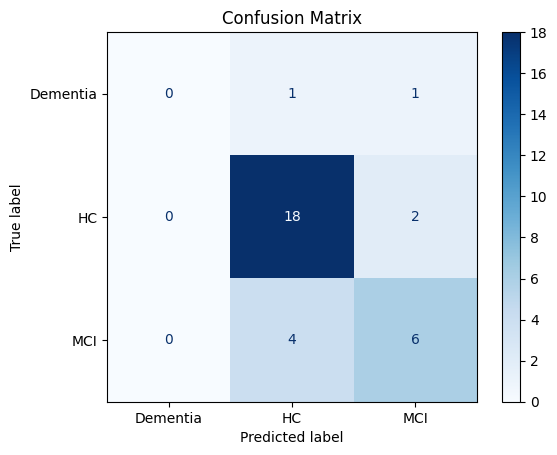

In [33]:


# Predict on test data
y_pred = pipeline.predict(X_test)

# Check the range of vectorized test data
vectorized_test = pipeline.named_steps['vectorizer'].transform(X_test)
print("Vectorized Test Data Range:", vectorized_test.min(), vectorized_test.max())


# Get prediction probabilities with corrected scaling
log_probabilities = pipeline.named_steps['classifier'].predict_log_proba(pipeline.named_steps['vectorizer'].transform(X_test))
probabilities = softmax(pipeline.named_steps['classifier'].predict_log_proba(pipeline.named_steps['vectorizer'].transform(X_test)))


# Evaluate the model
print(classification_report(y_test, y_pred))

# Save features for debugging
X_train_features['label'] = y_train
X_test_features['label'] = y_test

# Save processed data for review
X_train_features.to_csv("PFT-train_features.csv", index=False)
X_test_features.to_csv("PFT-test_features.csv", index=False)

# Save predictions and scores for review
predictions_with_scores_df = pd.DataFrame({
    'record_id': test_record_ids,
    'text': X_test,
    'true_label': y_test,
    'predicted_label': y_pred,
    'score_0': probabilities[:, 0],
    'score_1': probabilities[:, 1]
})

predictions_with_scores_df.to_csv("PFT-predictions_with_scores_NaiveBayes.csv", index=False)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()